In [1]:
import pandas as pd
import numpy as np 
import pymc3 as pm 
import matplotlib.pyplot as plt 
import pymc3 as pm 


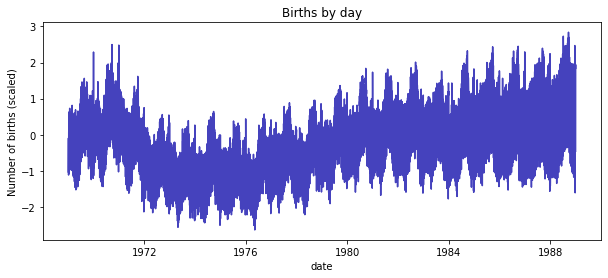

In [25]:
bdays = pd.read_csv("birthdates-1968-1988.csv")
bdays["date"] = pd.to_datetime(bdays[["year","month","day"]])

# scale the data
births_mu = bdays["births"].mean(axis=0)
births_sig = bdays["births"].std(axis=0)
bdays["births_sc"] = (bdays["births"] - births_mu) / births_sig

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(bdays["date"], bdays["births_sc"], c='#4542bd')
ax.set_title("Births by day")
ax.set_xlabel("date")
ax.set_ylabel("Number of births (scaled)")
plt.show()

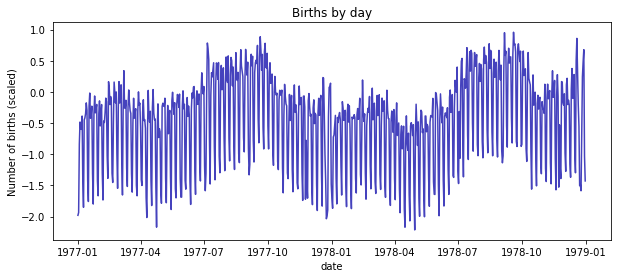

In [27]:
bd_zoom = bdays.query("year >= 1977 and year < 1979")

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(bd_zoom["date"], bd_zoom["births_sc"], c='#4542bd')
ax.set_title("Births by day")
ax.set_xlabel("date")
ax.set_ylabel("Number of births (scaled)")
plt.show()

Fit a Gaussian process via `PyMC3`

In [29]:
with pm.Model() as GPModel:

    # use 5 covariance kernels

    # long-term: squared exponential
    lam_1 = pm.Uniform('lam_1', lower=0, upper=10)
    sig_1 = pm.HalfCauchy("sig_1", beta=10)
    cov_1 = sig_1 * pm.gp.cov.ExpQuad(input_dim=1, ls=lam_1)
    f_1 = pm.gp.Marginal(cov_func=cov_1)

    # short-term: squared exponential
    lam_2 = pm.Uniform('lam_2', lower=0, upper=10)
    sig_2 = pm.HalfCauchy("sig_2", beta=10)
    cov_2 = sig_2 * pm.gp.cov.ExpQuad(input_dim=1, ls=lam_2)
    f_2 = pm.gp.Marginal(cov_func=cov_2)

    # short-term weekly trend: squared exponential
    lam_31 = pm.Uniform('lam_31', 0, 10)
    lam_32 = pm.Uniform('lam_32', 0, 10)
    sig_3 =pm.HalfCauchy('sig_3', 10)
    cov_3 = sig_3 * pm.gp.cov.ExpQuad(1, lam_31) * pm.gp.cov.Periodic(1,7,lam_32)
    f_3 = pm.gp.Marginal(cov_func=cov_3)

    # short-term yearly trend: sq exp
    lam_41 = pm.Uniform('lam_41', 0, 10)
    lam_42 = pm.Uniform('lam_42', 0, 10)
    sig_4 = pm.HalfCauchy('sig_4', 10)
    cov_4 = sig_3 * pm.gp.cov.ExpQuad(1, lam_41) * pm.gp.cov.Periodic(1,365.25,lam_42)
    f_4 = pm.gp.Marginal(cov_func=cov_4)


    # glue it all together
    sig = pm.HalfCauchy("sigma", 10)
    gp = f_1 + f_2 + f_3 + f_4 # Deterministic?

    y_like = gp.marginal_likelihood('y_obs', 
        X = np.expand_dims(bd_zoom.index.to_numpy(), axis=1),
        y = bd_zoom["births_sc"].values,
        noise = sig,
        )
    advi_fit = pm.fit(
        method = 'advi',
        n = 4500,
        obj_optimizer = pm.adagrad(learning_rate=1e-1)
    )



Interrupted at 986 [21%]: Average Loss = 506.03
